# Wine Quality Prediction

This notebook analyses the Red Wine Quality dataset and builds machine learning models to predict wine quality from 
<br>physicochemical properties such as acidity, alcohol and sulphates.

The workflow includes:
1. Exploratory Data Analysis (EDA)
2. Data preprocessing and feature engineering
3. Training and evaluating machine learning models
4. Drawing conclusion on feature importance and predictive performance

## 1. Import Libraries

We start by importing the required Python libraries for:
- **Data handling**: pandas, numpy
- **Visualisation**: matplotlib, seaborn
- **Machine learning**: scikit-learn (for models and evaluation)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## 2. Load Dataset

The dataset contains physcochemical properties of red wines (e.g., acidity, sugar, sulphates) and a quality
<br>score ranging from 0–10 assigned by wine experts.

We first load the dataset into a pandas DataFrame and check its dimensions and first few records.

In [30]:
file_path = "../data/winequality-red.csv"
df = pd.read_csv(file_path)

print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,NaN,34.0,0.9978,3.51,0.56,9.4,5.10
1,7.8,0.88,0.00,2.6,0.098,NaN,67.0,0.9968,3.20,0.68,9.8,5.09
2,7.8,0.76,0.04,2.3,0.092,NaN,54.0,0.9970,3.26,0.65,9.8,5.66
3,11.2,0.28,0.56,1.9,0.075,NaN,60.0,0.9980,3.16,0.58,9.8,6.15
4,7.4,0.70,0.00,1.9,0.076,NaN,34.0,0.9978,3.51,0.56,9.4,5.99


## 3. Exploratory Data Analysis (EDA)

Before modelling, we explore the dataset to understand its structure, spot missing values, 
<br>duplicate values and identify potential correlations

### 3.1 Missing and Duplicate Values

- **Duplicate rows** represent redundant entries of the same observation.  
  Keeping them can bias the model by over-representing certain samples, leading to skewed results and misleading performance metrics.  
- **Missing values** reduce the usable dataset size and may cause errors during model training. Depending on their extent, they can be 
  imputed (filled in) or the affected rows/columns can be dropped.  

Here we check for duplicates and missing values across all columns to assess whether data cleaning steps are required before analysis.

In [31]:
duplicates = df.duplicated().sum()
missing = df.isnull().sum()
total_missing = df.isnull().sum().sum()

print(f"Number of duplicate rows: {duplicates}")
print(f"Number of missing values in rows: \n{missing}")
print(f"Total number of missing values in dataset: {total_missing}")

Number of duplicate rows: 2
Number of missing values in rows: 
fixed acidity             0
volatile acidity          0
citric acid               0
residual sugar            0
chlorides                 0
free sulfur dioxide     187
total sulfur dioxide      0
density                  91
pH                       19
sulphates                 0
alcohol                   0
quality                   0
dtype: int64
Total number of missing values in dataset: 297


### 3.2 Summary Statistics & Outliers

Summary statistics provide an overview of feature distributions:  
- **Mean and standard deviation** reveal central tendency and spread.
- **Minimum and maximum values** help spot extreme cases.
- **Quartiles (Q1, Q3)** are useful for detecting outliers.

Outliers can occur due to measurement error, data entry mistakes or rare but valid cases. 

In predictive modelling:
- Some models (like **Linear Regression**) are highly sensitive to outliers,
  as they distort the regression line.
- Others (like **tree-based models**) are more robust but may still
  assign disproportionate importance to unusual values.

By reviewing the distributions, we decide whether outlier treatment
(e.g. capping, removal or transformation) is necessary.


In [32]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1412.000000,1599.000000,1508.000000,1580.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.784703,46.467792,0.996741,3.311373,0.658149,10.500344,6.128643
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.455011,32.895324,0.001902,0.154087,0.169507,1.714084,0.860368
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.030000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.480000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.080000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997800,3.400000,0.730000,11.100000,6.720000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,39.500000,8.940000


#### Scatterplots with Outlier Highlighting

Scatterplots help visualise the relationship between individual features and quality.  
By marking points that fall outside the mean ± 3 standard deviations,  
we can easily spot unusual values that may distort model training.

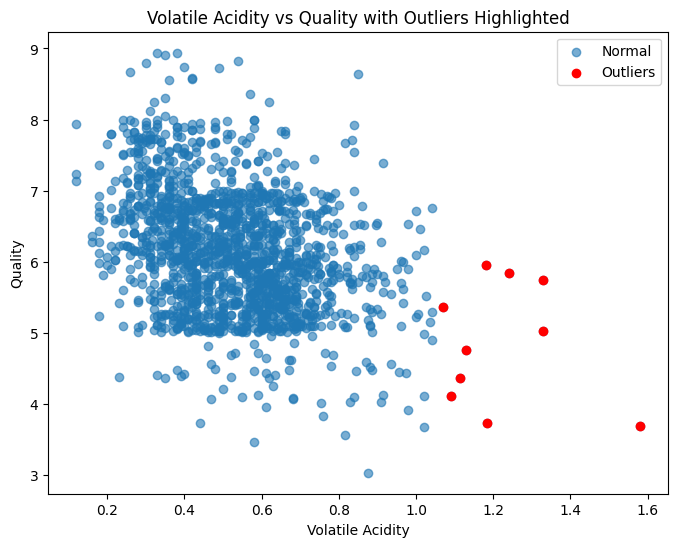

Detected 10 outliers in volatile acidity


In [33]:
# Example for volatile acidity vs. quality
mean_acidity = df["volatile acidity"].mean()
std_acidity = df["volatile acidity"].std()

outliers = (df["volatile acidity"] > mean_acidity + 3*std_acidity) | \
            (df["volatile acidity"] < mean_acidity - 3*std_acidity)

plt.figure(figsize=(8,6))
plt.scatter(df["volatile acidity"], df["quality"], alpha=0.6, label="Normal")
plt.scatter(df.loc[outliers, "volatile acidity"], df.loc[outliers, "quality"], color="red", label="Outliers")
plt.xlabel("Volatile Acidity")
plt.ylabel("Quality")
plt.title("Volatile Acidity vs Quality with Outliers Highlighted")
plt.legend()
plt.savefig("../results/volatile_acidity_outliers.png")
plt.show()

print(f"Detected {outliers.sum()} outliers in volatile acidity")

#### Handling Outliers

In practice, there are several strategies:

- **Keep them** if they are genuine and the model can handle them (e.g. Random Forest)
- **Remove them** if they are measurement errors or distort linear models
- **Transform them** using scaling or winsorisation (capping extreme values)

For this project, we keep outliers for Random Forest (robust to extremes), but may compare results 
<br>with and without outliers for Linear Regression to highlight sensitivity.

### 3.3 Correlation Analysis

Correlation analysis quantifies the linear relationship between features and the target.  

- A **positive correlation** means the feature increases with quality 
  (e.g. higher alcohol content generally indicates better quality).
- A **negative correlation** means the feature decreases with quality 
  (e.g. higher volatile acidity often reduces perceived wine quality).
- A correlation near **0** suggests no strong linear relationship.

This step helps us:
1. Identify the most influential features for prediction.
2. Spot potential **multicollinearity** (when two features are highly correlated), 
   which can weaken models like Linear Regression.
3. Decide whether feature reduction or transformation is needed.

The heatmap visualisation provides an intuitive overview of how each variable contributes to wine quality.


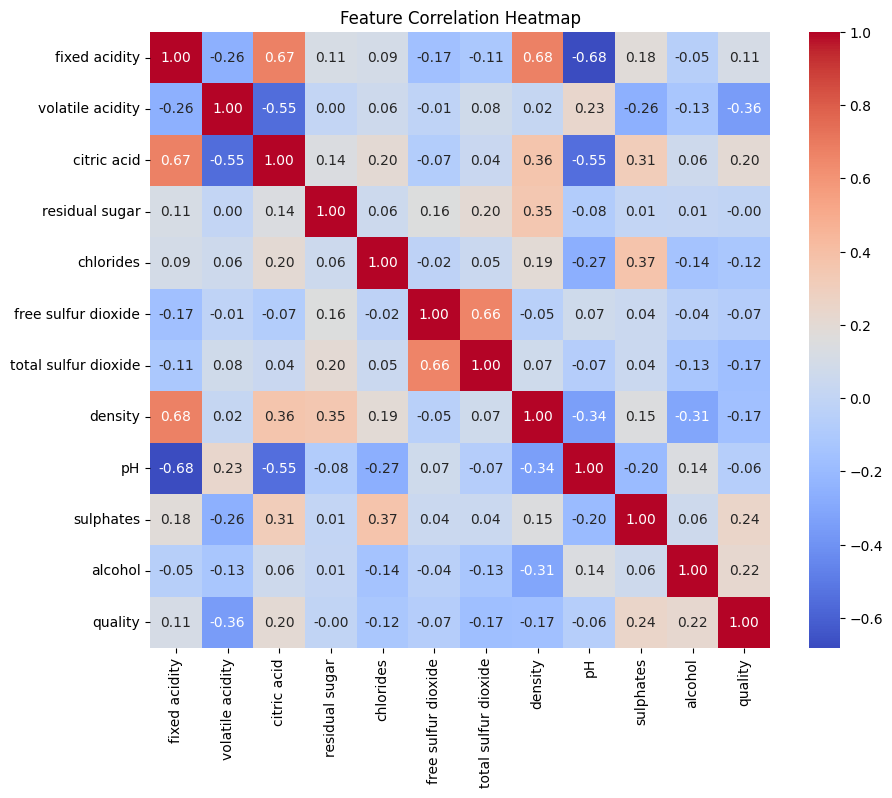

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig("../results/correlation_heatmap.png")
plt.show()

## 4 Feature Engineering

Based on the exploratory analysis, we now prepare the dataset for modelling.

- **Features (x):** the physicochemical properties of the wine
- **Target (y):** the wine quality score

Since the dataset consists entirely of numeric features, no categorical encoding is required.
<br>Scaling is not strictly necessary for tree-based models, but may improve performance for algorithms like Linear Regression or Gradient Descent–based models.

In [35]:
# Define features and target
X = df.drop("quality", axis=1)
y = df["quality"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (1599, 11)
Target vector shape: (1599,)


### 4.1 Handling Missing Values and Duplicates

Data quality issues can bias model performance if not addressed.

- **Missing values (NaNs):**
  <br>Linear Regression and many scikit-learn models cannot handle NaNs.
  <br>We use **mean imputation**, replacing missing values with the column mean.
  <br>This preserves dataset size and provides a simple but effective fix.

- **Duplicate rows:**
  <br>Duplicates represent redundant entries of the same wine.
  <br>If kept, they would overweight certain samples and distort learning.
  <br>We remove them to ensure each wine is only represented once.

In [36]:
# Removing duplicates
print("Duplicates before removal:", X.duplicated().sum())
X = X.drop_duplicates()
y = y.loc[X.index]
print("Duplicates after removal:", X.duplicated().sum())

# Handling missing values with mean imputation
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Converting back to DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

print("Remaining NaNs after imputation:", np.isnan(X).sum().sum())

Duplicates before removal: 207
Duplicates after removal: 0
Remaining NaNs after imputation: 0


## 5. Model Training

## 5.1 Train/Test Split

To evaluate model performance fairly, we split the dataset into **training data** and **testing data**:

- **Training set (80%)** → used to fit the model and learn patterns.
- **Testing set (20%)** → held back and used only for final evaluation on unseen data.

Using a fixed `random_state` ensures the split is reproducible, so results are consistent across different runs.  

This prevents **overfitting**, where a model memorises the training data instead of learning generalisable patterns.

In [37]:
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1113, 11)
Testing set shape: (279, 11)


## 5.2 Linear Regression

Linear Regression is a simple baseline model:

- It assumes a **linear relationship** between input features and the target variable.
- The model minimises squared errors to find the best-fitting line.
- While easy to interpret, it struggles when relationships are non-linear or when outliers distort the regression line.

We use this as a **baseline model** - more advanced models should aim to outperform it, justifying their added complexity.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lin_reg.predict(X_test)

# Evaluate performance
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression R Squared Value:", r2_lr)
print("Linear Regression RMSE:", rmse_lr)

Linear Regression R Squared Value: 0.31419463717048934
Linear Regression RMSE: 0.7597598679251029


## 5.3 Random Forest Regressor

Random Forest is an **ensemble method** that combines multiple decision trees:

- Each tree is trained on a random subset of the data and features (bagging).
- Predictions are averaged across trees, which reduces overfitting.
- The model captures **non-linear relationships** and **feature interactions**, making it more powerful than Linear Regression for structured tabular data.  
- Feature importance can be extracted, showing which wine properties most strongly influence quality.  

We train a Random Forest model on the same dataset and evaluate its performance against Linear Regression.


In [41]:
# Train Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluate performance
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R Squared Value:", r2_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest R Squared Value: 0.39348480398602004
Random Forest RMSE: 0.7144909862709017


## 6. Model Evaluation

We now compare the performance of the two models:

- **Linear Regression** (baseline, assumes linearity)
- **Random Forest Regressor** (non-linear, ensemble method)

We evaluate them using:

- **R squared value (Coefficient of Determination):**
<br>Measures the proportion of varience in wine quality explained by the model, where higher is better

- **RMSE (Root Mean Squared Error):**
<br>Represents the average prediction error, in the same units as the target (0–10), where lower is better

This side-by-side comparison helps us assess whether Random Forest provides a significant improvement over the baseline.

In [43]:
# Collect results into a DataFrame
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R Squared": [r2_lr, r2_rf],
    "RMSE": [rmse_lr, rmse_rf]
})

results

,Model,R Squared,RMSE
0,Linear Regression,0.314195,0.759760
1,Random Forest,0.393485,0.714491
